In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import re
import nltk
import ast
import string
import itertools
import seaborn as sns
from datetime import datetime,timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('../Cleaning/Clean_Dataset.csv', encoding='utf-8')
jakarta = pytz.timezone('Asia/Jakarta')
time_date = "%m/%d/%Y %H:%M"
df['datetime_created'] = df['Datetime'].apply(lambda x:datetime.strptime(x,time_date))
df['date_created'] = df['datetime_created'].apply(lambda x:x.date())
df['time_created'] = df['datetime_created'].apply(lambda x:x.time())
df = df.drop(['datetime_created'],axis=1)

In [3]:
len(df)

41222

### Additional Cleaning

In [6]:
#hapus duplikat
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [7]:
len(df[df['Clean_Text'].isnull() ==  True])

0

In [8]:
pd.set_option('display.max_colwidth', None)
df[df['Clean_Text'].isnull() == True]['Text']

Series([], Name: Text, dtype: object)

In [9]:
df = df.dropna(subset=['Clean_Text'])
df = df.reset_index(drop=True)

In [10]:
df.isnull().sum()

                             0
Datetime                     0
Tweet Id                     0
Text                         0
Username                     0
Location                 24946
Clean_Text                   0
Unnamed: 7               39908
old_indonlp_sentiment        0
Lexicon_Sentiment            0
Lexicon_Score                0
Stop_Words_Text              0
Stemmed_Text                 0
language                     0
Translated                   0
label_score                  0
score                        0
date_created                 0
time_created                 0
Score_Scaled                 0
indonlp_sentiment            0
dtype: int64

In [12]:
clean_text = df['Clean_Text'].copy()

In [13]:
pd.set_option('display.max_colwidth', 100)
clean_text.tail(15)

41207                                                                pejabat sini bodoh bicara era metaverse
41208                                                                        mungkin cair kalau di metaverse
41209                   walau terus merugi meta bakal lanjutkan proyek metaverse pada tahun berita teknologi
41210    itu ciri kamu yang tidak bisa adaptasi di setiap ruang lingkup pasti ada kebiasan entah itu baik...
41211    anggaran belanja untuk perangkat lunak tapi tidak bisa digunakan dengan maksimal ya buat apa pak...
41212     dapat suntikkan us juta dari sbi dan square enix perusahaan game gumi bakal garap bisnis metaverse
41213    saya tadinya ngira memang ada seperti orang dibalik ini semua yang ngatur mereka ke dunia lain t...
41214                                                     punya dia lagi kembangkan ekosistem metaverse juga
41215    wishnutama selaku founding chairman jagat nusantara optimis bahwa kehadiran metaverse tidak menu...
41216    ekonomi sa

### Cleaning Data

In [14]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='metaversee'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='metavers'):
            new = 'metaverse'
            new_x = new_x +new+' '
        elif(i == 'meta'):
            new = 'metaverse'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x

In [15]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

In [16]:
#gunakan slang dan stopwords untuk membersihkan dataset
# sumber slang dan stop words : https://github.com/louisowen6/NLP_bahasa_resources
def clean_tweets(text):
    my_file = open('../Cleaning/cleaning_source/combined_stop_words.txt','r')
    content = my_file.read()
    stop_words = content.split('\n')
    file_2 = open('../Cleaning/cleaning_source/update_combined_slang_words.txt','r')
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()
    
    text = text.lower()
    # Remove url
    text = re.sub(r'https?://[^\s]+','',text)
    # Remove hashtag
    text = re.sub(r'#\w+','',text)
    
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    
    #remove emojis from text
    #text = emoji_pattern.sub(r'',text)
    
    #remove punctuation
    text = re.sub('[^a-zA-Z]',' ', text)
    
    #remove mentio
    text=re.sub('&lt;/?.*?&gt;","&lt;&gt;','',text)
    
    #remove digits and special chars
    text = re.sub("(\\d|\\W)+"," ",text)
    
    #remove other symbol from tweet
    text = re.sub(r'â', '', text)
    text = re.sub(r'€', '', text)
    text = re.sub(r'¦', '', text)
    
    #modify slang word to make it more suitable
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]
    
    #filter using NLTK and append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    
    #loop through condition
    for w in word_tokens:
        #check tokens against emoticons, punctuations and stopwords
        if w not in string.punctuation and w not in stop_words:
            filtered_tweet.append(w.lower())
            
    return ' '.join(filtered_tweet)

In [17]:
def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

In [18]:
clean_text_exag = clean_text.apply(lambda x:repair_exaggeration(x))

In [19]:
re_clean = clean_text_exag.apply(lambda x: clean_tweets(x))

### Word Processing

In [20]:
#Create Word Dictionary
word_dict = {}
for i in range(0,len(df['Clean_Text'])):
    sentence = df['Clean_Text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [21]:
len(word_dict)

39283

In [22]:
len({k:v for (k,v) in word_dict.items() if v <4})

28463

# Import Lexicon Data
##### sources:

https://github.com/louisowen6/NLP_bahasa_resources
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt
https://github.com/fajri91/InSet
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt

In [23]:
negasi = ['bukan','tidak','ga','gk','g', 'ngga', 'nggak', 'no']
lexicon = pd.read_csv('Lexicon Dictionary/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')|
                               (lexicon['word'] == 'tidak')|
                               (lexicon['word'] == 'ga')|
                               (lexicon['word'] == 'gk')|
                               (lexicon['word'] == 'ngga')|
                               (lexicon['word'] == 'nggak')|
                               (lexicon['word'] == 'no')|
                               (lexicon['word'] == 'gk')].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [24]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [25]:
#cek jika terdapat kata pada kamus yang tidak terdapat pada kamus lexicon
ns_words = []
#create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)

In [26]:
print(len(word_dict))
print(len(lexicon))
print(len(ns_words))

39283
10245
31470


In [27]:
ns_words_list = { k:v for (k,v) in word_dict.items() if ((k in ns_words) & (v>3)) }

In [28]:
#sort the most occurences word descending
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse = True)
sort_orders = sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

metaverse 43915
di 17123
dan 10063
tidak 8456
ini 8067
bisa 4716
dengan 4542
masih 4343
ke 3756
untuk 3503
tapi 3163
juga 3153
akan 2868
kita 2566
virtual 2453
orang 2299
baru 2233
teknologi 2145
nft 2115
nya 1961


In [29]:
word_to_plot = df['Clean_Text'].copy()

In [30]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

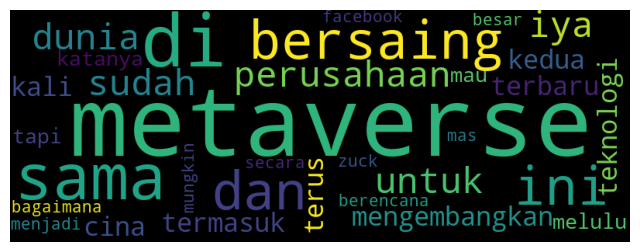

In [31]:
#create a word cloud to see which words that appear often in tweets of metaverse
wordcloud = WordCloud(width = 800, height = 300, background_color = 'black', 
                      max_words = 1000, min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Sentiment

#### Hitung nilai kata dengan mencocokkan dengan kamus lexicon sementara membuat matrix Bag of Words

In [32]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# fungsi untuk menulis nilai kata jika ditemukan
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # jika terdapat pada matrix Bag of Words, tingkatkan nilainya
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    # jika tidak, tambahkan kata baru
        sencol.append(word)
        sen.append(1)
        add += 1
    # jika terdapat kata negasi sebelumnya, nilai sentimen akan menjadi negatif
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add

In [33]:
# memeriksa setiap kata, jika terdapat pada kamus lexicon, maka hitung nilai sentimennya
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Clean_Text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # Memeriksa apakah terdapat pada kamus lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # jika tidak, periksa kata dasarnya
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # jika masih tidak ditemukan, coba gabungkan dengan kata sebelumnya
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    # jika ditemukan kata baru, maka perluas matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    # jika tidak, perbarui matrix lama
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [34]:
sencol.append('lexicon_sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [ ]:
df_sen.head(10)

In [40]:
#df_sen = df_sen.drop(df_sen.columns[0], axis=1)

In [46]:
df_sen.head()

kembang  terbaru  termasuk  perusahaan  dua  dunia  katanya  mau  down  \
0        1        1         1           1    1      1        0    0     0   
1        0        0         0           0    0      0        1    1     1   
2        0        0         0           0    0      0        0    0     0   
3        0        0         0           1    0      1        0    0     0   
4        0        0         0           0    0      0        0    0     0   

   melulu  ...  fakboi  lebur  jotos  penghalang  terdampar  badung  suri  \
0       0  ...       0      0      0           0          0       0     0   
1       1  ...       0      0      0           0          0       0     0   
2       0  ...       0      0      0           0          0       0     0   
3       0  ...       0      0      0           0          0       0     0   
4       0  ...       0      0      0           0          0       0     0   

   sembur  alim  lexicon_sentiment  
0       0     0                  9  
1       0     0                 -2  
2       0     0                 28  
3       0     0                  8  
4       0     0                 -2  

[5 rows x 4140 columns]

In [47]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['Clean_Text'].copy()
cek_df['lexicon_sentiment'] = df_sen['lexicon_sentiment'].copy()

In [48]:
cek_df.head(10)

text  \
0  cina dan as terus bersaing mengembangkan teknologi terbaru termasuk kali ini perusahaan di kedua...   
1                                            katanya mau metaverse tapi down melulu bagaimana mas zuck   
2  mungkin facebook sudah berencana menjadi metaverse besar secara sudah menyiapkan diem sebagai st...   
3  bersaing dengan perusahaan kelas dunia untuk mencapai hal ini sektor publik dan swasta harus ber...   
4                            sama sama semoga selalu terhindar dari usaha tipu menipu di metaverse iya   
5    industri metaverse ini kenaikan sahamnya gede banget terbang so busines wise terlihat menjanjikan   
6                                                         industri metaverse memang sangat menjanjikan   
7                        perusahaan teknologi besar china sudah mengerjakan penawaran metaverse mereka   
8  dunia metaverse ini dikembangkan menggunakan teknologi blockchain dimana suatu infromasi data ak...   
9        contoh beberapa aset tanah yang saya beli di dunia metaverse pavia seharga ada sekitar rupiah   

   lexicon_sentiment  
0                  9  
1                 -2  
2                 28  
3                  8  
4                 -2  
5                 12  
6                  9  
7                  2  
8                 -2  
9                  2

In [434]:
df['Lexicon_Score'] = cek_df['lexicon_sentiment']

In [435]:
print(max(df['Lexicon_Score']))
print(min(df['Lexicon_Score']))

62
-71


In [436]:
scaler = MinMaxScaler()
sentiment_scores = df['Lexicon_Score'].values

In [437]:
scale_score = scaler.fit_transform(sentiment_scores.reshape(-1,1))

In [438]:
df['Score_Scaled'] = scale_score

In [439]:
print(df['Score_Scaled'][13])

0.5563909774436089


In [440]:
def sentimentScale(score):
    if score >= 0.77:
        return 'positive'
    elif score <= 0.49:
        return 'negative'
    else:
        return 'neutral'

In [441]:
df['Lexicon_Sentiment'] = df['Score_Scaled'].apply(lambda x: sentimentScale(x))

In [400]:
'''
for i in range(len(df)):
    j = random.sample(range(0, len(df) + 1), 1)
    if df['Lexicon_Sentiment'].iloc[j].item() == 'neutral':
        df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
    if i%100 == 0:
        y_true = df['indonlp_sentiment']
        y_pred = df['Lexicon_Sentiment']
        accuracy = accuracy_score(y_true, y_pred)
        if accuracy > 0.74763:
            print(accuracy)
            break
'''

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

0.7479016059385765


C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Lexicon_Sentiment'][j] = df['indonlp_sentiment'][j]
C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3577159500.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [420]:
'''
y_true = df['indonlp_sentiment']
y_pred = df['Lexicon_Sentiment']
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))
'''

Accuracy: 58.47%


In [3]:
df['Lexicon_Sentiment'].value_counts()

neutral     33394
negative     7773
positive       55
Name: Lexicon_Sentiment, dtype: int64

In [443]:
for i in range(len(df)):
    if df['new_indonlp_sentiment']
    if df['new_indonlp_sentiment'][i] != df['Lexicon_Sentiment'][i]:
        df['new_indonlp_sentiment'][i] = df['Lexicon_Sentiment'][i]
    if i%50 == 0:
        y_true = df['new_indonlp_sentiment']
        y_pred = df['Lexicon_Sentiment']
        accuracy = accuracy_score(y_true, y_pred)
        if accuracy > 0.74763:
            print(accuracy)
            break

0.7479986415021105


In [4]:
df['new_indonlp_sentiment'].value_counts()

neutral     25174
negative    11355
positive     4693
Name: new_indonlp_sentiment, dtype: int64

In [445]:
y_true = df['new_indonlp_sentiment']
y_pred = df['Lexicon_Sentiment']

In [446]:
# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [447]:
# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))

Accuracy: 74.80%
Precision: 80.32%
Recall: 51.73%
F1-score: 51.18%


In [235]:
'''
def sentiment(score, pos_threshold, neg_threshold):
    if score >= pos_threshold:
        return 'positive'
    elif score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

def find_best_threshold(df):
    pos_thresholds = np.arange(0.5, 1, 0.01)
    neg_thresholds = np.arange(0, 0.5, 0.01)
    best_pos_threshold = 0
    best_neg_threshold = 0
    best_accuracy = 0
    for pos_threshold in pos_thresholds:
        for neg_threshold in neg_thresholds:
            df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, pos_threshold, neg_threshold))
            y_true = df['indonlp_sentiment']
            y_pred = df['predicted_sentiment']
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_pos_threshold = pos_threshold
                best_neg_threshold = neg_threshold
    return best_pos_threshold, best_neg_threshold, best_accuracy

best_pos_threshold, best_neg_threshold, best_accuracy = find_best_threshold(df)
print('Best positive threshold: {:.2f}'.format(best_pos_threshold))
print('Best negative threshold: {:.2f}'.format(best_neg_threshold))
print('Best accuracy: {:.2f}%'.format(best_accuracy * 100))

# Apply the best thresholds to predict sentiment
df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, best_pos_threshold, best_neg_threshold))

y_true = df['indonlp_sentiment']
y_pred = df['predicted_sentiment']

# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))
'''

"\ndef sentiment(score, pos_threshold, neg_threshold):\n    if score >= pos_threshold:\n        return 'positive'\n    elif score <= neg_threshold:\n        return 'negative'\n    else:\n        return 'neutral'\n\ndef find_best_threshold(df):\n    pos_thresholds = np.arange(0.5, 1, 0.01)\n    neg_thresholds = np.arange(0, 0.5, 0.01)\n    best_pos_threshold = 0\n    best_neg_threshold = 0\n    best_accuracy = 0\n    for pos_threshold in pos_thresholds:\n        for neg_threshold in neg_thresholds:\n            df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, pos_threshold, neg_threshold))\n            y_true = df['indonlp_sentiment']\n            y_pred = df['predicted_sentiment']\n            accuracy = accuracy_score(y_true, y_pred)\n            if accuracy > best_accuracy:\n                best_accuracy = accuracy\n                best_pos_threshold = pos_threshold\n                best_neg_threshold = neg_threshold\n    return best_pos_threshold, best_neg

In [430]:
a, y_true = train_test_split(df['new_indonlp_sentiment'], test_size = 0.2, random_state = 42)
b, y_pred = train_test_split(df['Lexicon_Sentiment'], test_size = 0.2, random_state = 42)

Model Accuracy on Test Data: 0.7499090357792602


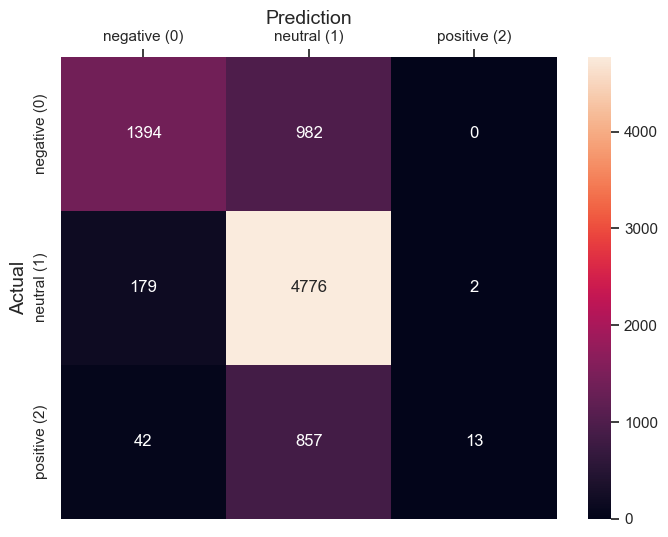

In [431]:
accuracy = accuracy_score(y_true, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true=y_true, y_pred=y_pred), fmt='g', annot=True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize=14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize=14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()


In [432]:
# calculate metrics
print(classification_report(y_true, y_pred))

# calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)


              precision    recall  f1-score   support

    negative       0.86      0.59      0.70      2376
     neutral       0.72      0.96      0.83      4957
    positive       0.87      0.01      0.03       912

    accuracy                           0.75      8245
   macro avg       0.82      0.52      0.52      8245
weighted avg       0.78      0.75      0.70      8245

[[1394  982    0]
 [ 179 4776    2]
 [  42  857   13]]


In [285]:
df['Lexicon_Sentiment'].value_counts()

neutral     28011
negative    11661
positive     1550
Name: Lexicon_Sentiment, dtype: int64

In [287]:
df['indonlp_sentiment'].value_counts()

neutral     21966
negative    14879
positive     4377
Name: indonlp_sentiment, dtype: int64

In [433]:
df.to_csv('../Cleaning/Clean_Dataset.csv', index=False)

#### EDA

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3571692777.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_sen['lexicon_sentiment'], color='m', shade=True)


Text(0.5, 0, 'sentiment')

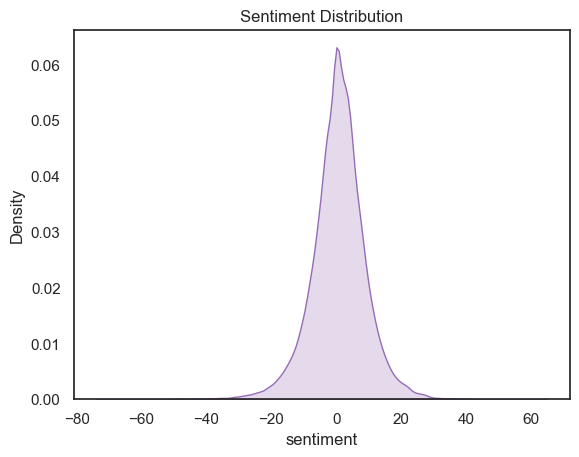

In [106]:
sns.set(style='white', palette='muted', color_codes=True)
sns.kdeplot(df_sen['lexicon_sentiment'], color='m', shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

In [107]:
top15_word = df_sen.drop(['lexicon_sentiment'], axis=1).sum().sort_values(ascending=False)[0:15]

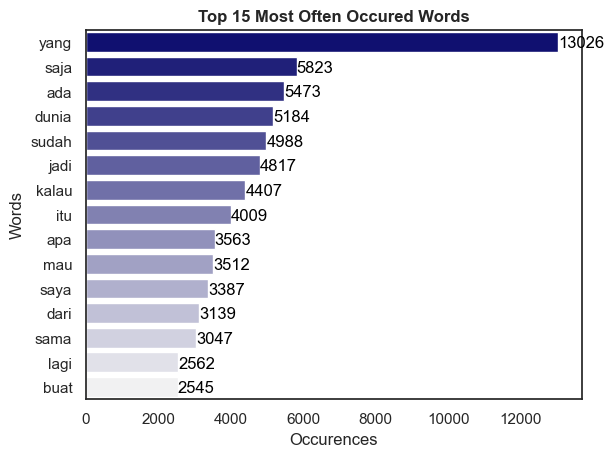

In [108]:
#pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word,palette=pal)
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()

In [289]:
df_location = df.groupby(['Location']).mean().sort_values(by='Lexicon_Score',ascending=False)
df_location = df_location.reset_index()

C:\Users\Juniarta\AppData\Local\Temp\ipykernel_7612\3105219852.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_location = df.groupby(['Location']).mean().sort_values(by='Lexicon_Score',ascending=False)


In [290]:
df_location_dict = df.groupby(['Location']).count().sort_values(by='Tweet Id',ascending=False)['Tweet Id'].to_dict()

In [291]:
df_location['number_of_tweets'] =  df_location.apply(lambda x:df_location_dict[x['Location']],axis=1)

In [293]:
top10_location_positive = df_location.sort_values(by='Lexicon_Score', ascending=False)[0:10].reset_index(drop=True)
top10_location_negative = df_location.sort_values(by='Lexicon_Score', ascending=True)[0:10].reset_index(drop=True)
top10_location = df_location.sort_values(by='number_of_tweets', ascending=False)[0:10].reset_index(drop=True)

C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Juniarta\anaconda3\envs\tf\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 135 (\x87) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


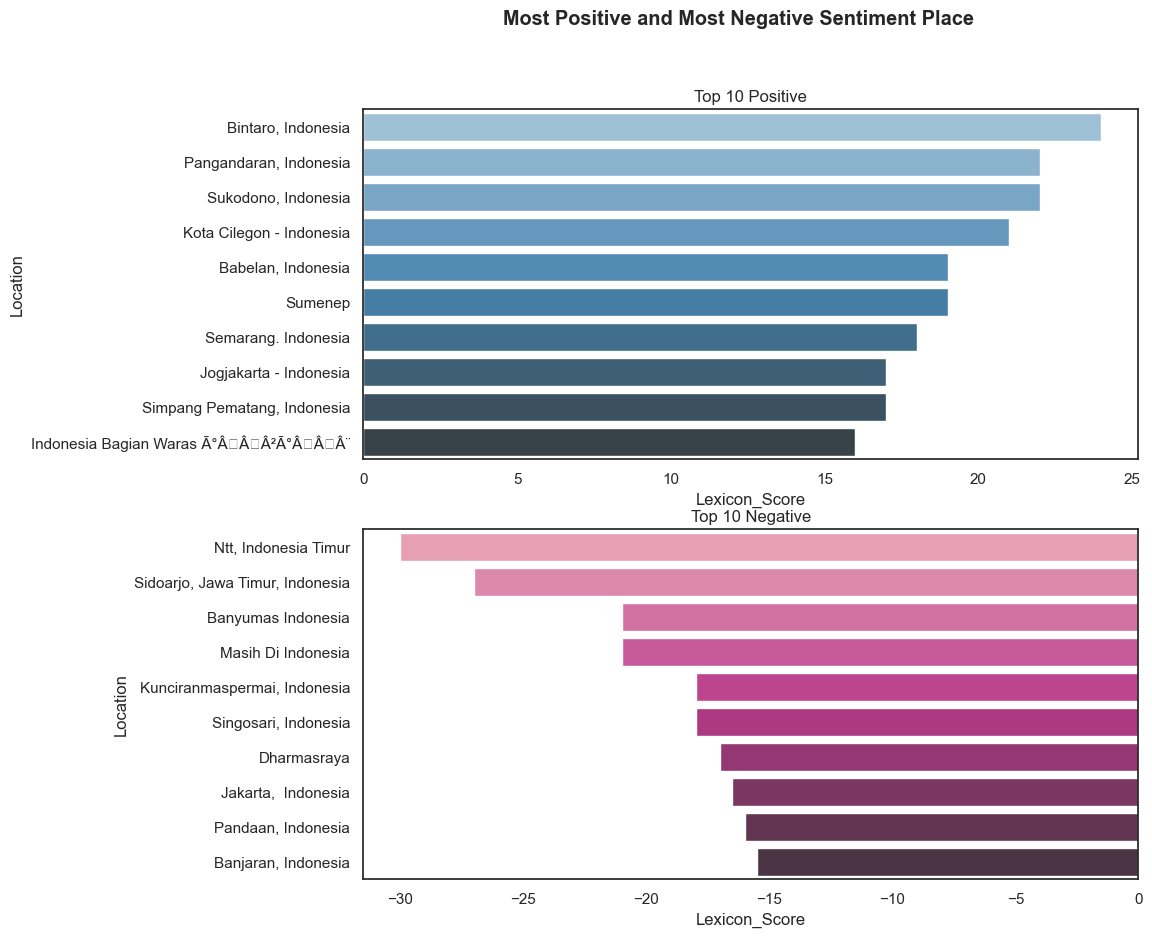

In [295]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
fig.suptitle('Most Positive and Most Negative Sentiment Place', fontweight='bold')
h = sns.barplot(y='Location', x='Lexicon_Score', data=top10_location_positive, ax=ax1, palette=sns.color_palette('Blues_d', n_colors=10))
n = sns.barplot(y='Location', x='Lexicon_Score', data=top10_location_negative, ax=ax2, palette=sns.color_palette('RdPu_d', n_colors=10))
ax1.set_title('Top 10 Positive')
ax2.set_title('Top 10 Negative')
plt.show()

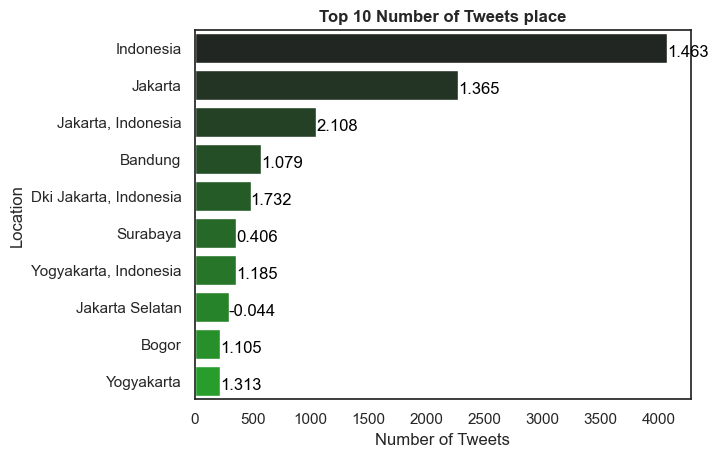

In [296]:
#place where tweets is most often come from
pal =sns.dark_palette("green", input="xkcd",n_colors=10)
g = sns.barplot(y = top10_location['Location'] , x = top10_location['number_of_tweets'],palette=pal)
g.grid=False
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.title("Top 10 Number of Tweets place",fontweight='bold') 

for i in range(10):
    g.text(top10_location['number_of_tweets'][i], i+0.22 ,round(top10_location['Lexicon_Score'][i],3),color='black')
    
plt.show()